# Vegetation Change

<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/Vegetation%20change.png" />
[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube)

This product uses changes in spectral indices such as NDVI, EVI and Fractional Cover to identify changes in vegetation. 

This notebook uses changes in NDVI, EVI or Fractional Cover to identify vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. Significant reductions in vegetation are coincident with land change. In some cases these changes could be deforestation. Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

### Import Required Modules

In [203]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import datacube
from matplotlib.cm import RdYlGn, Greens

from datacube_utilities.interactive_maps import display_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
# generic python
import xarray as xr 
import odc.algo
from shapely import wkt
from datetime import datetime
import numpy as np

from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.createindices import NDVI, EVI
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic, create_mean_mosaic
from pyproj import Proj, transform
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_png_from_xr, write_geotiff_from_xr
from datacube.utils.cog import write_cog

import dask
from dask.distributed import Client
client = Client('dask-scheduler.dask.svc.cluster.local:8786')

client.get_versions(check=True)
client

CMAP = "Blues"

### Initialise

In [205]:
# jupyteronly
# initialise
dc = datacube.Datacube(app = 'vegetation_change')#, config = '/home/localuser/.datacube.conf')
# Import Data Cube API


In [206]:

# jupyteronly
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

### Set Parameters for cube query

In [357]:
# parameters

#area of interest: load in as wkt
#parameter display_name="Area of Interest" description="The area for which the product is required." datatype="wkt",
# wakaya island - hit by cyclone winston in feb 2016  - dates end of JAn 2015-2016, start of March 2016 - 2017
#aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
aoi_wkt = "POLYGON((177.5029362281993 -18.156155117453817,177.53100286333114 -18.156155117453817,177.53100286333114 -18.18062057733904,177.5029362281993 -18.18062057733904,177.5029362281993 -18.156155117453817))"

#set start and end dates for time period of interest
#parameter display_name="Baseline Start Date" description='Start of the baseline time period window' datatype="date"
baseline_time_start = '1991-1-1'
#parameter display_name="Baseline End Date" description='End of the baseline time period window' datatype="date"
baseline_time_end = '1993-12-1'

#set start and end dates for time period of interest
#parameter display_name="Analysis Start Date" description='Start of the analysis time period window' datatype="date"
analysis_time_start = '1991-1-1'
#parameter display_name="Analysis End Date" description='End of the analysis time period window' datatype="date"
analysis_time_end = '1995-12-1'

#choose sensor
#parameter display_name="Baseline Sensor" description="Satellite to use for baseline time period." datatype="string" options=["sentinel_2", "landsat_4", "landsat_5", "landsat_7", "landsat_8"],
baseline_platform = "landsat_4"

#choose sensor
#parameter display_name="Analysis Sensor" description="Satellite to use for analysis time period." datatype="string" options=["sentinel_2", "landsat_4", "landsat_5", "landsat_7", "landsat_8"],
analysis_platform = "landsat_5"

#set resolution
#parameter display_name="Resolution (m)" description="Size of pixels" datatype="int" 
res = (30)

#parameter display_name="Coordinate Reference System (ESPG Code)" description="The EPSG code for the CRS, for Fiji this will be 3460." datatype="string" options=["3460", "3832"],
crs = "3460"

#parameter display_name="Mosaic Type" description="The type of mosaic." datatype="string" options=["max", "median", "geomedian", "mean"],
mosaic_type = "median"

#parameter display_name="Indices Type" description="The type of Indices." datatype="string" options=["EVI", "NDVI",  "FC"],
indices = "NDVI"

#parameter which determines what water threshold we accept as being water. Restrict to be between 0 and 1. 
#parameter display_name="Water Threshold" description="The value for how strict the water masking should be, ranging from 0 for always land and 1 for always water." datatype="float" options=[0,1]
waterThresh = 0.4

#parameter display_name="Vegetation Threshold Upper" description="Determines upper threshold for vegetation mask, typical values, for NDVI -0.7, typical for evi -1.75, typical for FC -70" datatype="float" options=[-100,100]
minC = -0.7

#parameter display_name="Vegetation Threshold Lower" description="Determines upper threshold for vegetation mask, typical values, for NDVI 0.2, typical for evi 0.5, typical for FC -20" datatype="float" options=[-100,100]
maxC = -0.2

### Reformat Parameters

In [358]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [359]:
# jupyteronly
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [360]:
#reprojection of AOI into input CRS and reformat
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:"+crs)
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3868901.244395433, 3871629.1723798118)
(1868059.9773457798, 1871011.4740391725)


In [361]:
allmeasurements = ["green","red","blue","nir","swir16","swir22"]
#water_measurements = ["water_classification"]
water_measurements = ['watermask']
def create_product_measurement(platform):
    if platform  in ["sentinel_2"]:
        product = 'sentinel_2'
        measurements = ["green","red","blue","nir08","swir16","swir22","scene_classification"]
        water_product = 'sentinel_2_mlwater'
    elif platform in ["landsat_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'landsat_8'
        water_product = 'landsat_8_mlwater'
    elif platform in ["landsat_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'landsat_7'
        water_product = 'landsat_7_mlwater'
    elif platform in ["landsat_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'landsat_5'
        water_product = 'landsat_5_mlwater'
    elif platform in ["landsat_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'landsat_4'
        water_product = 'landsat_4_wofs'
    else:
        print("invalid platform")
    return product, measurements, water_product

#product, measurement, water_product = create_product_measurement(platform)

allmeasurements = ["green","red","blue","nir","swir1","swir2"] #Question
water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        water_product = 's2_water_mlclassification'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls8_usgs_sr_scene'
        water_product = 'ls8_water_mlclassification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls7_usgs_sr_scene'
        water_product = 'ls7_water_mlclassification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product, measurements, water_product

In [362]:
#create resolution
resolution = (-res, res)

In [363]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [364]:
baseline_product, baseline_measurement, baseline_water_product = create_product_measurement(baseline_platform)
analysis_product, analysis_measurement, analysis_water_product = create_product_measurement(analysis_platform)

In [365]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_time_start, baseline_time_end)
analysis_time_period = createDate(analysis_time_start, analysis_time_end)

print(baseline_time_period)

(datetime.date(1991, 1, 1), datetime.date(1993, 12, 1))


## Load data

In [366]:
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': "EPSG:"+crs,
    'resolution': resolution,
    'dask_chunks': dask_chunks,
    'crs': "EPSG:"+crs
}

In [367]:
baseline_ds = dc.load(
    time = baseline_time_period,
    platform = baseline_platform,
    product = baseline_product,
    measurements = baseline_measurement,
    **query
)
baseline_ds

<xarray.Dataset>
Dimensions:      (time: 9, x: 99, y: 92)
Coordinates:
  * time         (time) datetime64[ns] 1992-03-31 1992-04-16 ... 1993-03-25
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460
Data variables:
    green        (time, y, x) uint16 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    pixel_qa     (time, y, x) uint16 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

In [368]:
analysis_ds = dc.load(
    time = analysis_time_period,
    platform = analysis_platform,
    product = analysis_product,
    measurements = analysis_measurement,
    **query
)
analysis_ds

,Array,Chunk
Bytes,582.91 kB,18.22 kB
Shape,"(32, 92, 99)","(1, 92, 99)"
Count,82 Tasks,32 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,582.91 kB,18.22 kB
Shape,"(32, 92, 99)","(1, 92, 99)"
Count,82 Tasks,32 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk


### Check if loads are valid

In [369]:
def is_dataset_empty(ds:xr.Dataset) -> bool:
    checks_for_empty = [
                        lambda x: len(x.dims) == 0,      #Dataset has no dimensions
                        lambda x: len(x.data_vars) == 0  #Dataset no variables 
                       ]
    for f in checks_for_empty:
         if f(ds) == True:
                return True
    return False

In [370]:
if is_dataset_empty(baseline_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Baseline Dataset!")

In [371]:
if is_dataset_empty(analysis_ds): raise Exception("DataCube Load returned an empty Dataset." +  
                                               "Please check load parameters for Analysis Dataset!")

In [372]:
#rename S2 nir band from nir08 to nir
if baseline_platform  in ["sentinel_2"]:
    baseline_ds = baseline_ds.rename({'nir08': 'nir'})
else:
    print('correct bands exist')

correct bands exist


In [373]:
#rename S2 nir band from nir08 to nir
if analysis_platform  in ["sentinel_2"]:
    analysis_ds = analysis_ds.rename({'nir08': 'nir'})
else:
    print('correct bands exist')

correct bands exist


## Create Cloud Mask
Generating boolean masks that highlight valid pixels
Pixels must be cloud-free over land or water to be considered

In [374]:
def look_up_clean(platform, ds):
    if platform  in ["sentinel_2"]:
        good_quality = (
            (ds.scene_classification == 4) | # clear
            (ds.scene_classification == 5) | 
            (ds.scene_classification == 7) | 
            (ds.scene_classification == 2) | 
            (ds.scene_classification == 6)  #water
        )
    elif platform in ["landsat_8"]:  
        good_quality = (
            (ds.pixel_qa == 322)  | # clear
            (ds.pixel_qa == 386)  |
            (ds.pixel_qa == 834)  |
            (ds.pixel_qa == 898)  |
            (ds.pixel_qa == 1346) |
            (ds.pixel_qa == 324)  | # water
            (ds.pixel_qa == 388)  |
            (ds.pixel_qa == 836)  |
            (ds.pixel_qa == 900)  |
            (ds.pixel_qa == 1348)
        )
    elif platform in ["landsat_7", "landsat_5", "landsat_4"]:    
        good_quality = (
            (ds.pixel_qa == 66)  | # clear
            (ds.pixel_qa == 130) |
            (ds.pixel_qa == 68)  | # water
            (ds.pixel_qa == 132)  
        )
    else:
        print("invalid platform")
    return good_quality

In [375]:
b_good_quality = look_up_clean(baseline_platform, baseline_ds)
a_good_quality = look_up_clean(analysis_platform, analysis_ds)

In [376]:
baseline_ds_m1 = baseline_ds.where(b_good_quality)
analysis_ds_m1 = analysis_ds.where(a_good_quality)

baseline_ds_m1

<xarray.Dataset>
Dimensions:      (time: 9, x: 99, y: 92)
Coordinates:
  * time         (time) datetime64[ns] 1992-03-31 1992-04-16 ... 1993-03-25
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460
Data variables:
    green        (time, y, x) float64 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    red          (time, y, x) float64 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    blue         (time, y, x) float64 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    nir          (time, y, x) float64 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    swir16       (time, y, x) float64 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    swir22       (time, y, x) float64 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref

In [377]:
#carry out additional mask
maskoutofrange_b = ((baseline_ds_m1> 0) & (baseline_ds_m1 <= 10000))
baseline_ds_m2 = baseline_ds_m1.where(maskoutofrange_b != 0)
baseline_ds_masked = baseline_ds_m2
xx_clean_b = baseline_ds_m2

In [378]:
#carry out additional mask
maskoutofrange_a = ((analysis_ds_m1> 0) & (analysis_ds_m1 <= 10000))
analysis_ds_m2 = analysis_ds_m1.where(maskoutofrange_a != 0)
analysis_ds_masked = analysis_ds_m2
xx_clean_a = analysis_ds_m2

### Perform Mosaic

In [379]:
mosaic_function = {"median": create_median_mosaic,
                   "max": create_max_ndvi_mosaic,
                   "mean" : create_mean_mosaic}

In [380]:
if mosaic_type in ["geomedian"]: 
    scale, offset = (1/10_000, 0)  # differs per product, aim for 0-1 values in float32
    xx_clean_b_32 = to_f32(xx_clean_b, scale=scale, offset=offset)
    yy_b = xr_geomedian(xx_clean_b_32, 
                  num_threads=1,  # disable internal threading, dask will run several concurrently
                  eps=0.2*scale,  # 1/5 pixel value resolution
                  nocheck=True)   # disable some checks inside geomedian library that use too much ram

    baseline_composite = from_float(yy_b, 
                dtype='int16', 
                nodata=0, 
                scale=1/scale, 
                offset=-offset/scale)
    xx_clean_a_32 = to_f32(xx_clean_a, scale=scale, offset=offset)
    yy_a = xr_geomedian(xx_clean_a_32, 
                num_threads=1,  # disable internal threading, dask will run several concurrently
                eps=0.2*scale,  # 1/5 pixel value resolution
                nocheck=True)   # disable some checks inside geomedian library that use too much ram

    analysis_composite = from_float(yy_a, 
                dtype='int16', 
                nodata=0, 
                scale=1/scale, 
                offset=-offset/scale)
elif mosaic_type in ["median"]:   
    new_compositor = mosaic_function[mosaic_type]
    baseline_composite = new_compositor(baseline_ds_masked, clean_mask = b_good_quality, no_data = np.nan)
    analysis_composite = new_compositor(analysis_ds_masked, clean_mask = a_good_quality, no_data = np.nan)
elif mosaic_type in ["max", "mean"] and indices not in ['FC']:
    new_compositor = mosaic_function[mosaic_type]
    baseline_composite = dask.delayed(new_compositor)(baseline_ds_masked, clean_mask = b_good_quality, no_data = np.nan)
    analysis_composite = dask.delayed(new_compositor)(analysis_ds_masked, clean_mask = a_good_quality, no_data = np.nan)
elif mosaic_type in ["max", "mean"] and indices in ['FC']: # FC can't take a dask delayed object
    new_compositor = mosaic_function[mosaic_type]
    baseline_composite = new_compositor(baseline_ds_masked, clean_mask = b_good_quality, no_data = -9999)
    analysis_composite = new_compositor(analysis_ds_masked, clean_mask = a_good_quality, no_data = -9999)
    print('Finsihed composite')
else:
    print('broken')
baseline_composite

<xarray.Dataset>
Dimensions:      (x: 99, y: 92)
Coordinates:
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460
Data variables:
    green        (y, x) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    red          (y, x) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    blue         (y, x) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    nir          (y, x) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    swir16       (y, x) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    swir22       (y, x) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    pixel_qa     (y, x) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>

In [381]:
baseline_composite = baseline_composite.rename({"y": "latitude", "x":"longitude", "swir16":"swir1", 'swir22': 'swir2'})
analysis_composite = analysis_composite.rename({"y": "latitude", "x":"longitude", "swir16":"swir1", 'swir22': 'swir2'})
baseline_composite

<xarray.Dataset>
Dimensions:      (latitude: 92, longitude: 99)
Coordinates:
  * latitude     (latitude) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * longitude    (longitude) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460
Data variables:
    green        (latitude, longitude) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    red          (latitude, longitude) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    blue         (latitude, longitude) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    nir          (latitude, longitude) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    swir1        (latitude, longitude) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    swir2        (latitude, longitude) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>
    pixel_qa     (latitude, longitude) float64 dask.array<chunksize=(92, 99), meta=np.ndarray>

### Spectral Parameter

In [382]:
def createparametercomposite(indices, ds):
    '''Calculate the chosen indicies. 
    '''
    if indices in ['NDVI']:
        parameter_composite = NDVI(ds)
    elif indices in ['EVI']:
        parameter_composite = EVI(ds)
    elif indices in ['FC']:
        #parameter_baseline_composite2 = frac_coverage_classify(baseline, clean_mask = baseline_clean_masked.values, no_data=np.nan)
        parameter_composite_all = frac_coverage_classify(ds, no_data = np.nan) 
        parameter_composite = parameter_composite_all.pv.where(np.logical_not(np.isnan(ds.red.values)))
    return parameter_composite

In [383]:
parameter_baseline_composite = createparametercomposite(indices, baseline_composite)
parameter_analysis_composite = createparametercomposite(indices, analysis_composite)

### Generate Water Mask

In [384]:
def loadWaterMask(productInput, time_period):
    if productInput in ["sentinel_2_mlwater", "landsat_8_mlwater", "landsat_7_mlwater", "landsat_5_mlwater"]:
        water_scenes = dc.load(product=productInput,
                               measurements = ["water_ml", "waterprob_ml"],
                               time = time_period,
                               **query)
        if is_dataset_empty(water_scenes):
            print(productInput, 'is empty')
        #change clouds to no data value
        else:
            water_classes = water_scenes.where(water_scenes >= 0)
            good_quality_water = (
               (water_scenes.water_ml >= 0) & # no data
                (
                 (water_scenes.waterprob_ml <= 5) |
                    (water_scenes.waterprob_ml >= 100-5)
                )
                )
            water_classes = water_scenes.where(good_quality_water)
            water_classes['waterprob_ml'] = (100-water_classes['waterprob_ml']) # assign nodata vals consistent w/ other prods
            product_data = water_classes
    elif productInput in ["landsat_4_wofs"]:
        water_scenes = dc.load(product=productInput,
                               measurements = ["water_wofs"],
                               time = time_period,
                                   **query)
        if is_dataset_empty(water_scenes):
            print(productInput, 'is empty')
        else:
            water_classes1 = water_scenes.where(water_scenes != -9999)
            water_classes1['water_ml'] = water_classes1['water_wofs']
            water_classes = water_classes1.drop(['water_wofs'])
            product_data = water_classes
    else:
        print('invalid platform')
    return product_data

def loadWaterMask(productInput, time_period):
    if productInput in ["s2_water_mlclassification", "ls8_water_mlclassification", "ls7_water_mlclassification"]:
        water_scenes = dc.load(product=productInput,
                               measurements = ["watermask", "waterprob"],
                               time = time_period,
                                   **query)
        if is_dataset_empty(water_scenes):
            print(productInput, 'is empty')
        #change clouds to no data value
        else:
            water_classes = water_scenes.where(water_scenes >= 0)
            good_quality_water = (
               (water_scenes.watermask >= 0) & # no data
                (
                 (water_scenes.waterprob <= 5) |
                    (water_scenes.waterprob >= 100-5)
                )
                )
            water_classes = water_scenes.where(good_quality_water)
            water_classes['waterprob'] = (100-water_classes['waterprob']) # assign nodata vals consistent w/ other prods
            product_data = water_classes
    elif productInput in ["ls5_water_classification", "ls4_water_classification"]:
        water_scenes = dc.load(product=productInput,
                               measurements = ["water"],
                               time = time_period,
                                   **query)
        if is_dataset_empty(water_scenes):
            print(productInput, 'is empty')
        else:
            water_classes1 = water_scenes.where(water_scenes != -9999)
            water_classes1['watermask'] = water_classes1['water']
            water_classes = water_classes1.drop(['water'])
            product_data = water_classes
    else:
        print('invalid platform')
    return product_data

In [385]:
water_classes_baseline = loadWaterMask(baseline_water_product, baseline_time_period)
water_classes_analysis = loadWaterMask(analysis_water_product, analysis_time_period)

In [386]:
print(water_classes_baseline)

<xarray.Dataset>
Dimensions:      (time: 9, x: 99, y: 92)
Coordinates:
  * time         (time) datetime64[ns] 1992-03-31 1992-04-16 ... 1993-03-25
  * y            (y) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * x            (x) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460
Data variables:
    water_ml     (time, y, x) float64 dask.array<chunksize=(1, 92, 99), meta=np.ndarray>
Attributes:
    crs:           EPSG:3460
    grid_mapping:  spatial_ref


In [387]:
water_composite_baseline = water_classes_baseline.water_ml.mean(dim='time')

In [388]:
water_composite_analysis = water_classes_analysis.water_ml.mean(dim='time')

In [389]:
#water_composite_base = dask.delayed(water_classes_baseline.watermask.mean(dim='time'))

In [390]:
#water_composite_analysis = dask.delayed(water_classes_analysis.watermask.mean(dim='time'))

## Apply water mask

In [391]:
vegetation_baseline = parameter_baseline_composite.where(water_composite_baseline.values <= waterThresh).where(parameter_baseline_composite !=-9999) # RuntimeWarning: invalid value encountered 

In [392]:
#ds_clear_land = ds_clear.where(water_composite >= waterThresh)

In [393]:
vegetation_analysis = parameter_analysis_composite.where(water_composite_analysis.values <= waterThresh).where(parameter_analysis_composite !=-9999) # RuntimeWarning: invalid value encountered 

In [394]:
parameter_anomaly = vegetation_analysis - vegetation_baseline

In [395]:
%%time
parameter_anomaly_output = parameter_anomaly.compute()

CPU times: user 258 ms, sys: 3.96 ms, total: 262 ms
Wall time: 2.76 s


In [396]:
parameter_anomaly_output

<xarray.DataArray (latitude: 92, longitude: 99)>
array([[-0.06628011, -0.01169083,  0.00633911, ..., -0.08348309,
        -0.09203848, -0.07262072],
       [-0.05356768, -0.00421766, -0.00491966, ..., -0.08948119,
        -0.09724976, -0.09622725],
       [-0.01538144, -0.00191212, -0.02264319, ..., -0.07556707,
        -0.07947376, -0.08898408],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * latitude     (latitude) float64 3.872e+06 3.872e+06 ... 3.869e+06 3.869e+06
  * longitude    (longitude) float64 1.868e+06 1.868e+06 ... 1.871e+06 1.871e+06
    spatial_ref  int32 3460

# Spectral Parameter Anomaly

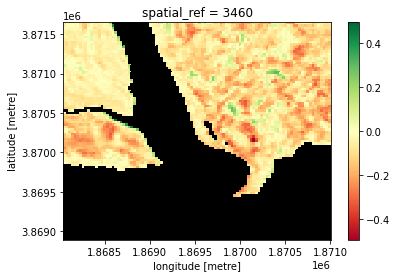

In [397]:
# jupyteronly
# Plot the parameter change from the baseline to the analysis period
# Significant loss in vegetation will be shown in RED
# Gains in vegetation will be shown in GREEN

#plt.figure(figsize = aspect_ratio_helper(parameter_anomaly)) 
parameter_anomaly_output.plot(cmap = RdYlGn)

# Anomaly Threshold Product

In [398]:
# jupyteronly
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

In [399]:
no_data_mask = np.isnan(parameter_anomaly_output)
a = parameter_anomaly_output

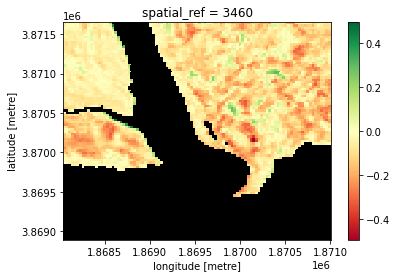

In [400]:
#jupyteronly
a.plot(cmap = "RdYlGn")

In [401]:
b = a.where((a < maxC) | (no_data_mask == True), 200) 

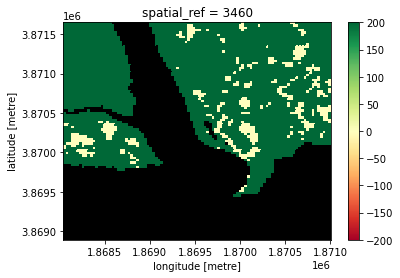

In [402]:
# jupyteronly
b.plot(cmap = "RdYlGn")

In [403]:
c = b.where((b > minC) | (no_data_mask == True), 300) 

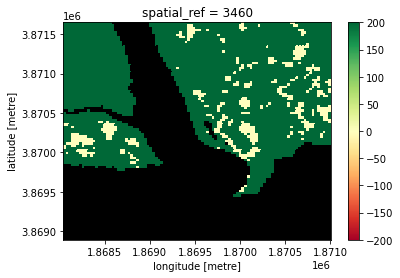

In [404]:
# jupyteronly
c.plot(cmap = "RdYlGn")

In [405]:
d = c.where(((c >= maxC) | (c <= minC)) | (no_data_mask == True), 100)

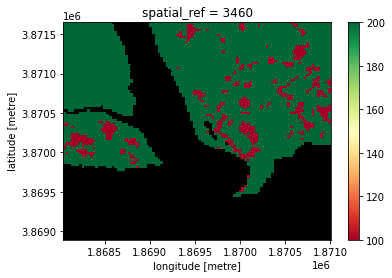

In [406]:
# jupyteronly
d.plot(cmap = "RdYlGn")

### Exports

In [407]:
#output = xr.DataArray.to_dataset(d, dim = None, name = 'param_thres')

In [408]:
#Write threshold product as COG.
write_cog(geo_im=d,
          fname='threshold.tif',
          overwrite=True)

PosixPath('threshold.tif')

In [409]:
#Write as gradient product as COG.
write_cog(geo_im=parameter_anomaly_output,
          fname='gradient.tif',
          overwrite=True)

PosixPath('gradient.tif')

In [410]:
#values of 300 are when the change is bigger than the minimum value, 200 when smaller, and 100 when within the range
#write_geotiff_from_xr('param_thres.tiff', output, ["param_thres"], crs="EPSG:"+crs, x_coord = 'longitude', y_coord = 'latitude')

In [411]:
#write_geotiff_from_xr('veg_change.tiff', parameter_anomaly_output, crs="EPSG:"+crs, x_coord = 'longitude', y_coord = 'latitude')

In [412]:
#naming exports for ESRI to pick up
['threshold.tif', 'gradient.tif' ]

['threshold.tif', 'gradient.tif']